In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage.color import rgb2gray

In [2]:
CIFAR_DIR = "C:/Users/Administrator/Desktop/cifar-10-batches-py"
train_data = []
train_labels = []
test_data = []
test_labels = []

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

for i in range(1, 4):
    img_dict = unpickle(os.path.join(CIFAR_DIR, 'data_batch_' + str(i)))
    hog_features = []
    for img in img_dict[b'data']:
        img = img.reshape(3, 32, 32)
        img = img.transpose(1, 2, 0)
        fd, hog_image = hog(rgb2gray(img), orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(hog_image.ravel())
    train_data.extend(hog_features)
    train_labels.extend(img_dict[b'labels'])

img_dict1 = unpickle(os.path.join(CIFAR_DIR, 'test_batch'))
hog_feature1 = []
for img in img_dict1[b'data']:
    img = img.reshape(3, 32, 32)
    img = img.transpose(1, 2, 0)
    fd, hog_image = hog(rgb2gray(img), orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    # test_data.append(hog_image)
    hog_feature1.append(hog_image.ravel())
test_data.extend(hog_feature1)
test_labels.extend(img_dict1[b'labels'])

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print('Training data shape: ', train_data.shape)
print('Training labels shape: ', train_labels.shape)
print('Test data shape: ', test_data.shape)
print('Test labels shape: ', test_labels.shape)

Training data shape:  (30000, 1024)
Training labels shape:  (30000,)
Test data shape:  (10000, 1024)
Test labels shape:  (10000,)


In [5]:
class LogisticRegression(object):
    def __init__(self, n_classes):
        self.W = None
        self.n_classes = n_classes

    def train(self,X,y,learning_rate=1e-2,reg=1e-5,num_iters=1000,
    batch_size=32,verbose=False,decay=False,early_stop=False):
        num_train,dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim,num_classes)
        pre_loss = []
        pre_train = []
        pre_test = []
        count_epoch = 0
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            index = np.random.choice(num_train,batch_size,replace=False)
            X_batch = X[index]
            y_batch = y[index]
            loss,dW = self.loss(X_batch,y_batch,reg)
            pre_loss.append(loss)
            self.W += -learning_rate * dW
            if (it + 1) % 200 == 0:
                count_epoch = count_epoch + 1
                if decay == True:
                    decay_rate = 0.01
                    learning_rate = learning_rate * (1 / (1 + decay_rate * it))
            if it % 200 == 0:
                batch_pred = self.predict(X_batch)
                num_correct = np.sum(batch_pred == y_batch)
                train_accuracy = float(num_correct) / X_batch.shape[0]
                test_pred = self.predict(X)
                test_correct = np.sum(test_pred == y)
                test_accuracy = float(test_correct) / X.shape[0]
                pre_train.append(train_accuracy)
                pre_test.append(test_accuracy)
                if early_stop == True and count_epoch > 1:
                    val_acc_diff = abs(pre_test[-1] - pre_test[-2])
                    if val_acc_diff < 1e-6:
                        print('Early stop at epoch %d' % count_epoch)
                        print('Early stop at iteration %d' % it)
                        break
        self.pre_loss = pre_loss
        self.pre_train = pre_train
        self.pre_test = pre_test
        return pre_loss

    def softmax_loss(W,X,y,reg):
        loss = 0.0
        dW = np.zeros(W.shape)
        num_train = X.shape[0]
        scores = X.dot(W)
        scores -= np.max(scores,axis=1,keepdims=True)
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores,axis=1,keepdims=True)
        correct_logprobs = -np.log(probs[range(num_train),y])
        loss = np.sum(correct_logprobs) / num_train
        loss += 0.5 * reg * np.sum(W * W)
        dscores = probs
        dscores[range(num_train),y] -= 1
        dscores /= num_train
        dW = np.dot(X.T,dscores)
        dW += reg * W
        return loss,dW

class Softmax(LogisticRegression):
    def loss(self,X,y,reg):
        return Softmax.softmax_loss(self.W,X,y,reg)

    def predict(self,X):
        y_pred = []
        scores = np.dot(X, self.W)
        y_pred = np.argmax(scores,axis=1)
        return y_pred




lr 5.000000e-02 train accuracy: 0.426367 test accuracy: 0.415800
lr 1.000000e-02 train accuracy: 0.376367 test accuracy: 0.366500
lr 1.000000e-03 train accuracy: 0.166500 test accuracy: 0.162400
lr 1.000000e-01 train accuracy: 0.447100 test accuracy: 0.433900
lr 5.000000e-01 train accuracy: 0.477633 test accuracy: 0.461700
lr 1.000000e+00 train accuracy: 0.482267 test accuracy: 0.470500


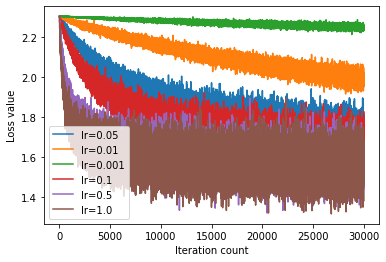

In [15]:
n_classes = 10
learning_rates = [5e-2, 1e-2, 1e-3, 0.1, 0.5, 1.0]
for lr in learning_rates:
    model = Softmax(n_classes = n_classes)
    loss_hist = model.train(train_data, train_labels, learning_rate=lr, reg=1e-5, num_iters=30000, batch_size=200, verbose=False)
    batch_pred = model.predict(train_data)
    num_correct = np.sum(batch_pred == train_labels)
    train_accuracy = float(num_correct) / train_data.shape[0]
    test_pred = model.predict(test_data)
    test_correct = np.sum(test_pred == test_labels)
    test_accuracy = float(test_correct) / test_data.shape[0]
    print('lr %e train accuracy: %f test accuracy: %f' % (lr, train_accuracy, test_accuracy))
    plt.plot(model.pre_loss, label=f'lr={lr}')

plt.xlabel('Iteration count')
plt.ylabel('Loss value')
plt.legend()
plt.show()

lr with decay start at 5.000000e-02 train accuracy: 0.120667 test accuracy: 0.116100
lr with decay start at 1.000000e-02 train accuracy: 0.109767 test accuracy: 0.106300
lr with decay start at 1.000000e-03 train accuracy: 0.104333 test accuracy: 0.102600
lr with decay start at 1.000000e-01 train accuracy: 0.171633 test accuracy: 0.166800
lr with decay start at 5.000000e-01 train accuracy: 0.328433 test accuracy: 0.322300
lr with decay start at 1.000000e+00 train accuracy: 0.377100 test accuracy: 0.366100


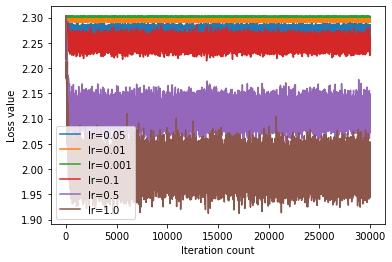

In [16]:
n_classes = 10
learning_rates = [5e-2, 1e-2, 1e-3, 0.1, 0.5, 1.0]
for lr in learning_rates:
    model = Softmax(n_classes = n_classes)
    loss_hist = model.train(train_data, train_labels, learning_rate=lr, reg=1e-5, num_iters=30000, batch_size=200, verbose=False, decay=True)
    batch_pred = model.predict(train_data)
    num_correct = np.sum(batch_pred == train_labels)
    train_accuracy = float(num_correct) / train_data.shape[0]
    test_pred = model.predict(test_data)
    test_correct = np.sum(test_pred == test_labels)
    test_accuracy = float(test_correct) / test_data.shape[0]
    print('lr with decay start at %e train accuracy: %f test accuracy: %f' % (lr, train_accuracy, test_accuracy))
    plt.plot(model.pre_loss, label=f'lr={lr}')

plt.xlabel('Iteration count')
plt.ylabel('Loss value')
plt.legend()
plt.show()

Early stop at epoch 120
Early stop at iteration 24000
lr 5.000000e-02 train accuracy: 0.419033 test accuracy: 0.407500
Early stop at epoch 147
Early stop at iteration 29400
lr 1.000000e-02 train accuracy: 0.375833 test accuracy: 0.365400
Early stop at epoch 88
Early stop at iteration 17600
lr 1.000000e-03 train accuracy: 0.139400 test accuracy: 0.135500
Early stop at epoch 143
Early stop at iteration 28600
lr 1.000000e-01 train accuracy: 0.446300 test accuracy: 0.432000
Early stop at epoch 87
Early stop at iteration 17400
lr 5.000000e-01 train accuracy: 0.470133 test accuracy: 0.454800
Early stop at epoch 62
Early stop at iteration 12400
lr 1.000000e+00 train accuracy: 0.474900 test accuracy: 0.458600


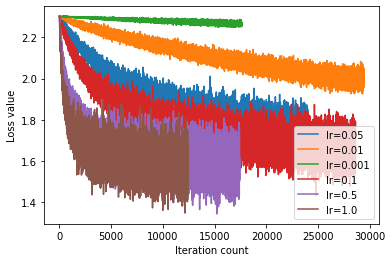

In [24]:
n_classes = 10
learning_rates = [5e-2, 1e-2, 1e-3, 0.1, 0.5, 1.0]
for lr in learning_rates:
    model = Softmax(n_classes = n_classes)
    loss_hist = model.train(train_data, train_labels, learning_rate=lr, reg=1e-5, num_iters=30000, batch_size=200, verbose=False, early_stop=True)
    batch_pred = model.predict(train_data)
    num_correct = np.sum(batch_pred == train_labels)
    train_accuracy = float(num_correct) / train_data.shape[0]
    test_pred = model.predict(test_data)
    test_correct = np.sum(test_pred == test_labels)
    test_accuracy = float(test_correct) / test_data.shape[0]
    print('lr %e train accuracy: %f test accuracy: %f' % (lr, train_accuracy, test_accuracy))
    plt.plot(model.pre_loss, label=f'lr={lr}')

plt.xlabel('Iteration count')
plt.ylabel('Loss value')
plt.legend()
plt.show()

gd method train accuracy: 0.458600 test accuracy: 0.447000
sgd method train accuracy: 0.473500 test accuracy: 0.457200


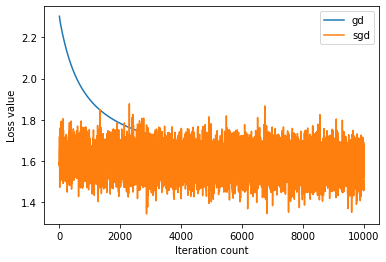

In [6]:
learning_rate = 5e-1
n_classes = 10

model = Softmax(n_classes = n_classes)
for i in range(2):
    if i == 0:
        loss_hist = model.train(train_data, train_labels, learning_rate=learning_rate, reg=1e-5, num_iters=10000, batch_size=train_data.shape[0], verbose=False)
        train_accuracy = np.mean(model.predict(train_data) == train_labels)
        test_accuracy = np.mean(model.predict(test_data) == test_labels)
        print('gd method train accuracy: %f test accuracy: %f' % (train_accuracy, test_accuracy))
        plt.plot(model.pre_loss, label=f'gd')
    else:
        loss_hist = model.train(train_data, train_labels, learning_rate=learning_rate, reg=1e-5, num_iters=10000, batch_size=200, verbose=False)
        train_accuracy = np.mean(model.predict(train_data) == train_labels)
        test_accuracy = np.mean(model.predict(test_data) == test_labels)
        print('sgd method train accuracy: %f test accuracy: %f' % (train_accuracy, test_accuracy))
        plt.plot(model.pre_loss, label=f'sgd')



plt.xlabel('Iteration count')
plt.ylabel('Loss value')
plt.legend()
plt.show()